In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import math
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
warnings.simplefilter("ignore")

# Files

train.csv - historical data including Sales

test.csv - historical data excluding Sales

sample_submission.csv - a sample submission file in the correct format

store.csv - supplemental information about the stores


# Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open
    
StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d
    
Assortment - describes an assortment level: a = basic, b = extra, c = extended
    
CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [2]:
store = pd.read_csv('store.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
store.shape

(1115, 10)

# Exploratory Data Analaysis

In [5]:
store.StoreType.unique()

array(['c', 'a', 'd', 'b'], dtype=object)

`There are 4 types of stores under Rossmann`

## Processing Missing Data

In [6]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [7]:
print(missing_values_table(store))

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.
                           Missing Values  % of Total Values
Promo2SinceWeek                       544               48.8
Promo2SinceYear                       544               48.8
PromoInterval                         544               48.8
CompetitionOpenSinceMonth             354               31.7
CompetitionOpenSinceYear              354               31.7
CompetitionDistance                     3                0.3


In [8]:
print(missing_values_table(train))

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


Observation : Only missing rows in store dataset

In [9]:
store[~store.Promo2SinceWeek.notnull()]['StoreType'].value_counts()

a    313
d    146
c     73
b     12
Name: StoreType, dtype: int64

In [10]:
store[~store.Promo2SinceYear.notnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


In [11]:
store[~store.PromoInterval.notnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


In [12]:
store['Promo2SinceWeek'] = store.Promo2SinceWeek.fillna(0)
store['Promo2SinceYear'] = store.Promo2SinceYear.fillna(0)
store['PromoInterval'] = store.PromoInterval.fillna(0)

In [13]:
store['CompetitionOpenSinceMonth'] = store.CompetitionOpenSinceMonth.fillna(0)
store['CompetitionOpenSinceYear'] = store.CompetitionOpenSinceYear.fillna(0)
store['CompetitionDistance'] = store.CompetitionDistance.fillna(0)

## Analysis

In [14]:
train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [15]:
print(missing_values_table(train))

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [16]:
train[train.Sales == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1
3105,876,3,2015-07-29,0,0,0,1,0,1
3636,292,2,2015-07-28,0,0,0,1,0,1
4220,876,2,2015-07-28,0,0,0,1,0,1
4751,292,1,2015-07-27,0,0,0,1,0,1
5335,876,1,2015-07-27,0,0,0,1,0,1


### Observation :

There are 172871 entries which show that the stores did not make any sales , so these won't be included in the analysis

In [17]:
train = train[train.Sales != 0]
dataset = pd.merge(train, store, how = 'inner', left_on = 'Store', right_on = 'Store')
dataset.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
5,1,6,2015-07-25,4364,500,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
6,1,5,2015-07-24,3706,459,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
7,1,4,2015-07-23,3769,503,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
8,1,3,2015-07-22,3464,463,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
9,1,2,2015-07-21,3558,469,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [18]:
dataset = dataset.sort_values(by = 'Date')

In [19]:
dataset.shape

(844338, 18)

In [20]:
original_dataset = dataset.copy(deep = False)

## Revenue Collection :  Store Type

In [21]:
revenue = pd.DataFrame(dataset.groupby('StoreType')['Sales'].sum())
revenue = revenue.reset_index()

In [22]:
revenue = revenue.sort_values(by = 'Sales', ascending = False)
revenue

,StoreType,Sales
0,a,3165334859
3,d,1765392943
2,c,783221426
1,b,159231395


### Observation : 

Store a makes the maximum sales among all the stores, whereas store b makes the least sales

<BarContainer object of 4 artists>

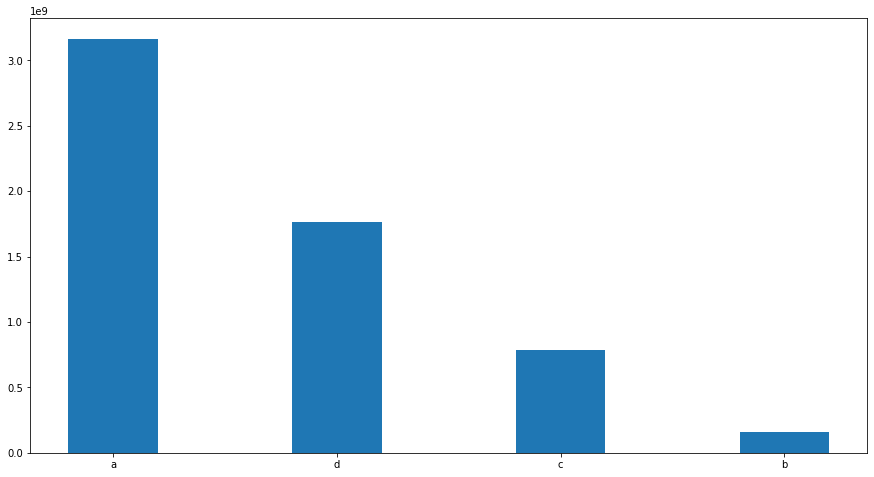

In [23]:
plt.figure(figsize = (15,8))
plt.bar(revenue['StoreType'], revenue['Sales'], width=0.4)

## Summary Statistic of Sales by StoreType

In [24]:
dataset.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


### Observations : 

 - Store B makes the highest average sales over the timeframe
 - There is a lot of variability in the sales of Store B
 - The minimum and maximum sales are made by A



In [25]:
dataset.groupby(['StoreType'])['Customers'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,795.422370,387.516543,8.0,547.0,720.0,949.0,7388.0
b,15560.0,2022.211825,910.687095,219.0,1255.0,1839.5,2751.0,5494.0
c,112968.0,815.538073,329.670020,18.0,583.0,756.0,981.0,3096.0
d,258768.0,606.353935,199.247092,64.0,464.0,577.0,716.0,2239.0


### Observations : 

 - Store A has the highest number of visitors, and B had the least number of visitors
 - On Average, store B has the highest number of visitors and also had the highest variability

In [26]:
def sales_per_customer(dataset):
    result_store_sales = pd.DataFrame(dataset.groupby('StoreType')['Sales'].sum())
    result_store_customers = pd.DataFrame(dataset.groupby('StoreType')['Customers'].sum())
    result_store_sales = result_store_sales.reset_index()
    result_store_customers = result_store_customers.reset_index()
    result_sales_customer = pd.merge(result_store_sales, result_store_customers, how = 'inner', left_on = 'StoreType', right_on = 'StoreType') 
    result_sales_customer['Sales_Per_Customer'] = result_sales_customer['Sales'].div(result_sales_customer['Customers'], axis = 0)
    return result_sales_customer

In [27]:
result_sales_customer = sales_per_customer(dataset)
result_sales_customer

,StoreType,Sales,Customers,Sales_Per_Customer
0,a,3165334859,363541431,8.706944
1,b,159231395,31465616,5.060489
2,c,783221426,92129705,8.501291
3,d,1765392943,156904995,11.251350


<BarContainer object of 4 artists>

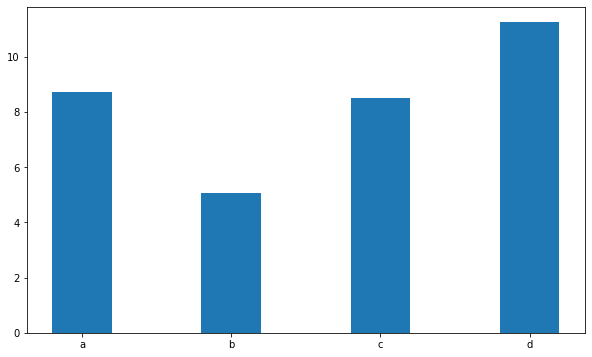

In [28]:
plt.figure(figsize = (10,6))
plt.bar(result_sales_customer['StoreType'], result_sales_customer['Sales_Per_Customer'],  width=0.4)

### Observation : 

Store D had the highest sales/customer followed by a,c and b

## Store Operational Days

In [29]:
dataset = dataset.reset_index()
dataset = dataset.iloc[:,1:]

In [30]:
dataset

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
1,353,2,2013-01-01,3139,820,1,0,a,1,b,b,900.0,0.0,0.0,1,14.0,2013.0,"Feb,May,Aug,Nov"
2,262,2,2013-01-01,17267,2875,1,0,a,1,b,a,1180.0,5.0,2013.0,0,0.0,0.0,0
3,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,6.0,2011.0,0,0.0,0.0,0
4,335,2,2013-01-01,2401,482,1,0,a,1,b,a,90.0,0.0,0.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
5,562,2,2013-01-01,8498,1675,1,0,a,1,b,c,1210.0,0.0,0.0,0,0.0,0.0,0
6,512,2,2013-01-01,2646,625,1,0,a,1,b,b,590.0,0.0,0.0,1,5.0,2013.0,"Mar,Jun,Sept,Dec"
7,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0
8,676,2,2013-01-01,3821,777,1,0,a,1,b,b,1410.0,9.0,2008.0,0,0.0,0.0,0
9,259,2,2013-01-01,6851,1444,1,0,a,1,b,b,210.0,0.0,0.0,0,0.0,0.0,0


In [31]:
def get_sales_by_day(dataset):
    weekly_sales = dataset.groupby(['StoreType','DayOfWeek'])['Sales'].sum().reset_index()
    store_type = []
    for store,c in zip(list(set(weekly_sales['StoreType'])) , ['red','skyblue','pink','orange']):
        data_store = weekly_sales[weekly_sales['StoreType'] == store].reset_index().iloc[:,1:]
        store_type.append(data_store)
        plt.figure(figsize = (15,8))
        plt.plot( 'DayOfWeek', 'Sales', data= data_store, marker='o', markerfacecolor='black', markersize=12, color= c , linewidth=4, label = store)
        plt.legend()
        
    store_type = pd.concat(store_type, axis = 1)    
    store_type = store_type.fillna(0)
    return store_type



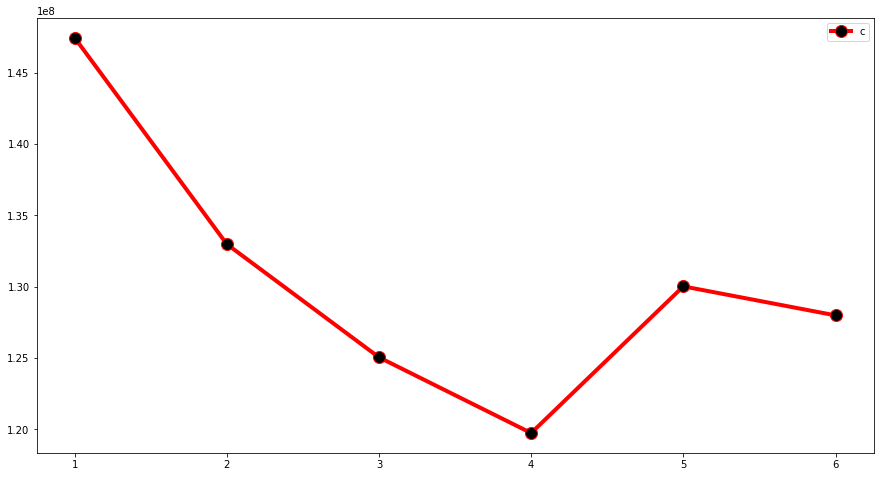

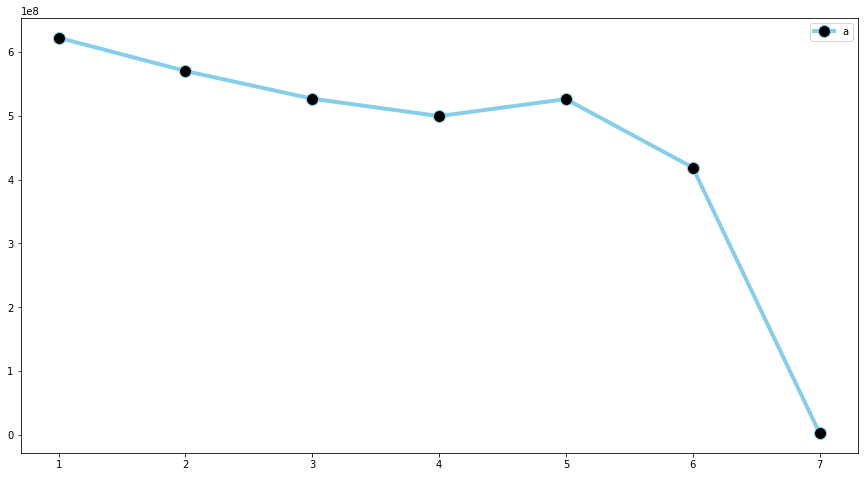

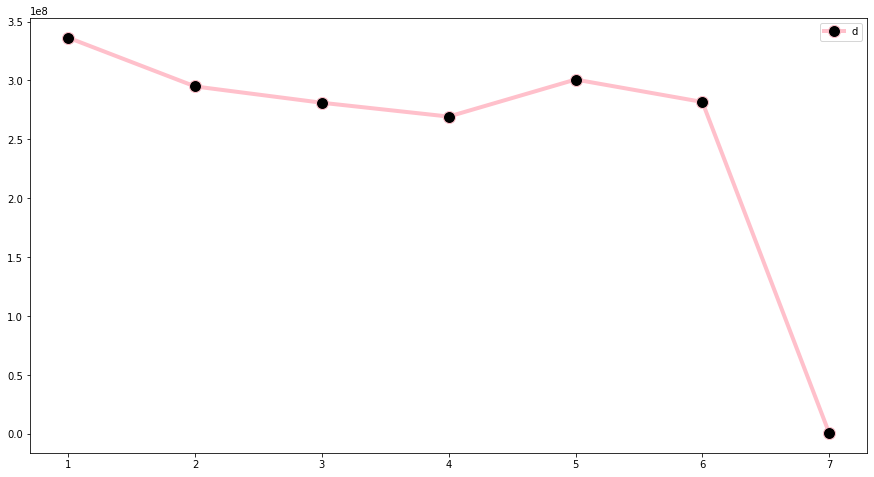

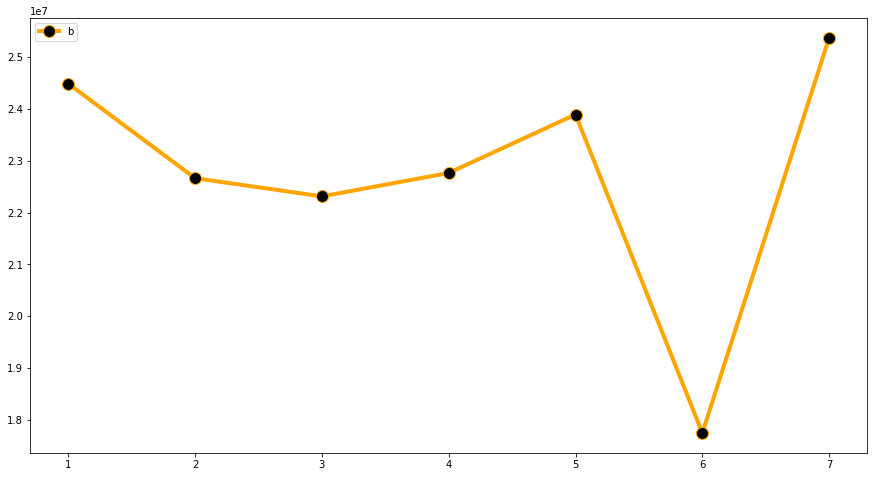

In [32]:
store_type = get_sales_by_day(dataset)

In [33]:
store_type

,StoreType,DayOfWeek,Sales,StoreType,DayOfWeek,Sales,StoreType,DayOfWeek,Sales,StoreType,DayOfWeek,Sales
0,c,1.0,147451826.0,a,1,621955243,d,1,336309063,b,1,24486880
1,c,2.0,132980408.0,a,2,569806300,d,2,294963059,b,2,22662163
2,c,3.0,125045659.0,a,3,526483032,d,3,281123330,b,3,22310842
3,c,4.0,119738778.0,a,4,499278350,d,4,269397774,b,4,22762807
4,c,5.0,130018737.0,a,5,525827656,d,5,300818753,b,5,23890795
5,c,6.0,127986018.0,a,6,418780958,d,6,281805850,b,6,17744909
6,0,0.0,0.0,a,7,3203320,d,7,975114,b,7,25372999


### Observation : 

 - Store C is closed on the 7th day of the week
 - Store B seems to have made the most sales on Sunday, followed by Store A and lastly by D
 - There is a sharp decline in sales from Saturday to Sunday for both stores A and D

In [34]:
del store_type

### Effect of Holidays : StateHoliday

a = Public holiday, b = Easter holiday, c = Christmas, 0 = None

In [35]:
store_sales_holiday = dataset.groupby(['StoreType','StateHoliday'])['Sales'].sum().reset_index()
store_sales_holiday = store_sales_holiday[store_sales_holiday.StateHoliday.isin(['a','b','c'])]

In [36]:
store_sales_holiday[store_sales_holiday.StateHoliday == 'a']

,StoreType,StateHoliday,Sales
2,a,a,1268495
7,b,a,3436106
12,c,a,490190
15,d,a,695514


In [37]:
store_sales_holiday[store_sales_holiday.StateHoliday == 'b']

,StoreType,StateHoliday,Sales
3,a,b,102069
8,b,b,1303845
16,d,b,27830


In [38]:
store_sales_holiday[store_sales_holiday.StateHoliday == 'c']

,StoreType,StateHoliday,Sales
4,a,c,16961
9,b,c,673045
17,d,c,1800


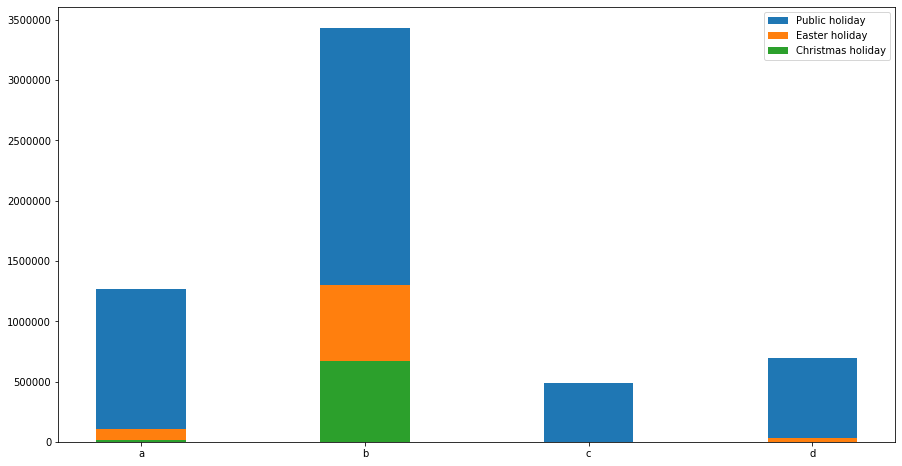

In [39]:
plt.figure(figsize = (15,8))
plt.bar(store_sales_holiday[store_sales_holiday.StateHoliday == 'a']['StoreType'], store_sales_holiday[store_sales_holiday.StateHoliday == 'a']['Sales'], label = 'Public holiday', width=0.4)
plt.bar(store_sales_holiday[store_sales_holiday.StateHoliday == 'b']['StoreType'], store_sales_holiday[store_sales_holiday.StateHoliday == 'b']['Sales'], label = 'Easter holiday', width=0.4)
plt.bar(store_sales_holiday[store_sales_holiday.StateHoliday == 'c']['StoreType'], store_sales_holiday[store_sales_holiday.StateHoliday == 'c']['Sales'], label = 'Christmas holiday', width=0.4)
plt.legend()

### Observation :

 - Store B earned the maximum on the Public holiday, followed by A, D and C in that order
 - Store B earned the maximum on the Easter holiday, followed by A and D in that order
 - Store B earned the maximum on the Christmas holiday, followed by A and D in that order
 - Store C didn't earn anything on Easter and Christmas holiday


In [40]:
del store_sales_holiday

### Effect of Holidays : SchoolHoliday

In [41]:
dataset.SchoolHoliday.value_counts()

0    680893
1    163445
Name: SchoolHoliday, dtype: int64

In [42]:
def sales_school(dataset):
    s = []
    store_school_relation = dataset.groupby(['StoreType','SchoolHoliday'])['Sales'].sum().reset_index()
    for store in list(set(store_school_relation.StoreType)):
        data = store_school_relation[store_school_relation.StoreType == store].reset_index()
        data['Percent_Contirbution'] = (data['Sales']/(sum(data['Sales']))) * 100
        s.append(data)
    s = pd.concat(s, axis = 0)
    s = s.reset_index().iloc[:,1:]
    s = s.iloc[:,1:]
    return s

In [43]:
store_school_relation = sales_school(dataset)

In [44]:
store_school_relation

,StoreType,SchoolHoliday,Sales,Percent_Contirbution
0,c,0,625084685,79.809447
1,c,1,158136741,20.190553
2,a,0,2522985483,79.706748
3,a,1,642349376,20.293252
4,d,0,1418123236,80.329042
5,d,1,347269707,19.670958
6,b,0,130067127,81.684348
7,b,1,29164268,18.315652


In [45]:
store_school_relation.dtypes

StoreType                object
SchoolHoliday             int64
Sales                     int64
Percent_Contirbution    float64
dtype: object

### Observation  : 

From the above dataframe we can observe that school's operational hours had some impact on the sales for each store type

In [46]:
del store_school_relation

### Effect of Promo on Sales by Store

In [47]:
sales_promo = dataset.groupby(['StoreType','Promo','Promo2'])['Sales'].sum().reset_index()
sales_promo

,StoreType,Promo,Promo2,Sales
0,a,0,0,821855188
1,a,0,1,645116361
2,a,1,0,933884921
3,a,1,1,764478389
4,b,0,0,71961446
5,b,0,1,20100464
6,b,1,0,51374754
7,b,1,1,15794731
8,c,0,0,210043504
9,c,0,1,165143153


### Observation :

Looking across the different store types, we can observe that among all stores , only store D had higher sales when it started Promotional Offer 2, all other sales had higher sales during Promotional Offer 1

# Forecasting Model : Predicting Sales By Store

In [48]:
store_a = dataset[dataset.StoreType == 'a']
store_b = dataset[dataset.StoreType == 'b']
store_c = dataset[dataset.StoreType == 'c']
store_s = dataset[dataset.StoreType == 'd']

In [49]:
del store

In [50]:
store_a  = store_a.reset_index().iloc[:,1:]
store_a

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,530,2,2013-01-01,2907,532,1,0,a,1,a,c,18160.0,0.0,0.0,0,0.0,0.0,0
1,773,3,2013-01-02,5955,864,1,0,0,1,a,a,200.0,0.0,0.0,0,0.0,0.0,0
2,712,3,2013-01-02,6377,615,1,0,0,1,a,a,4870.0,9.0,2007.0,1,45.0,2009.0,"Jan,Apr,Jul,Oct"
3,929,3,2013-01-02,5011,663,1,0,0,1,a,c,4820.0,9.0,2013.0,0,0.0,0.0,0
4,276,3,2013-01-02,3406,538,1,0,0,1,a,a,2960.0,10.0,2014.0,1,36.0,2013.0,"Mar,Jun,Sept,Dec"
5,195,3,2013-01-02,10405,1322,1,0,0,1,a,c,220.0,0.0,0.0,0,0.0,0.0,0
6,142,3,2013-01-02,5198,671,1,0,0,1,a,a,1090.0,7.0,2002.0,0,0.0,0.0,0
7,364,3,2013-01-02,2774,433,1,0,0,1,a,c,13620.0,0.0,0.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
8,1099,3,2013-01-02,11883,1477,1,0,0,1,a,c,200.0,4.0,2013.0,1,14.0,2013.0,"Jan,Apr,Jul,Oct"
9,558,3,2013-01-02,2463,394,1,0,0,1,a,a,3000.0,2.0,2010.0,0,0.0,0.0,0


In [51]:
store_a = store_a[['Date','Sales']]

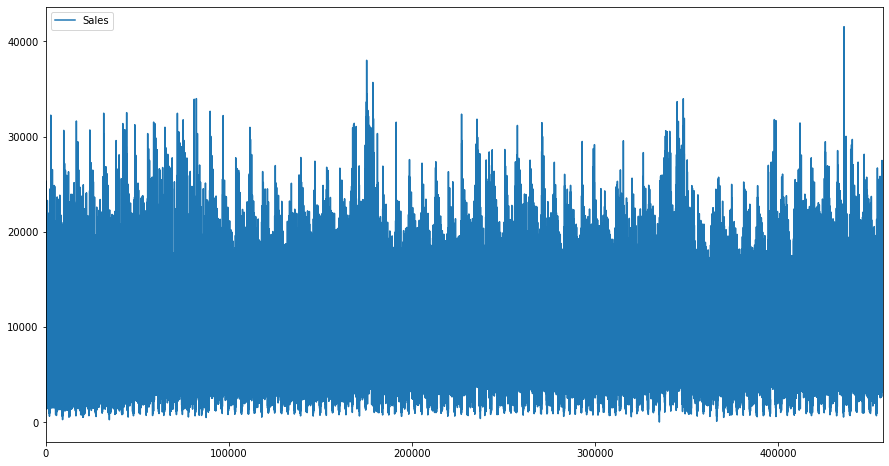

In [52]:
store_a.plot(figsize = (15,8), kind= 'line')
plt.show()

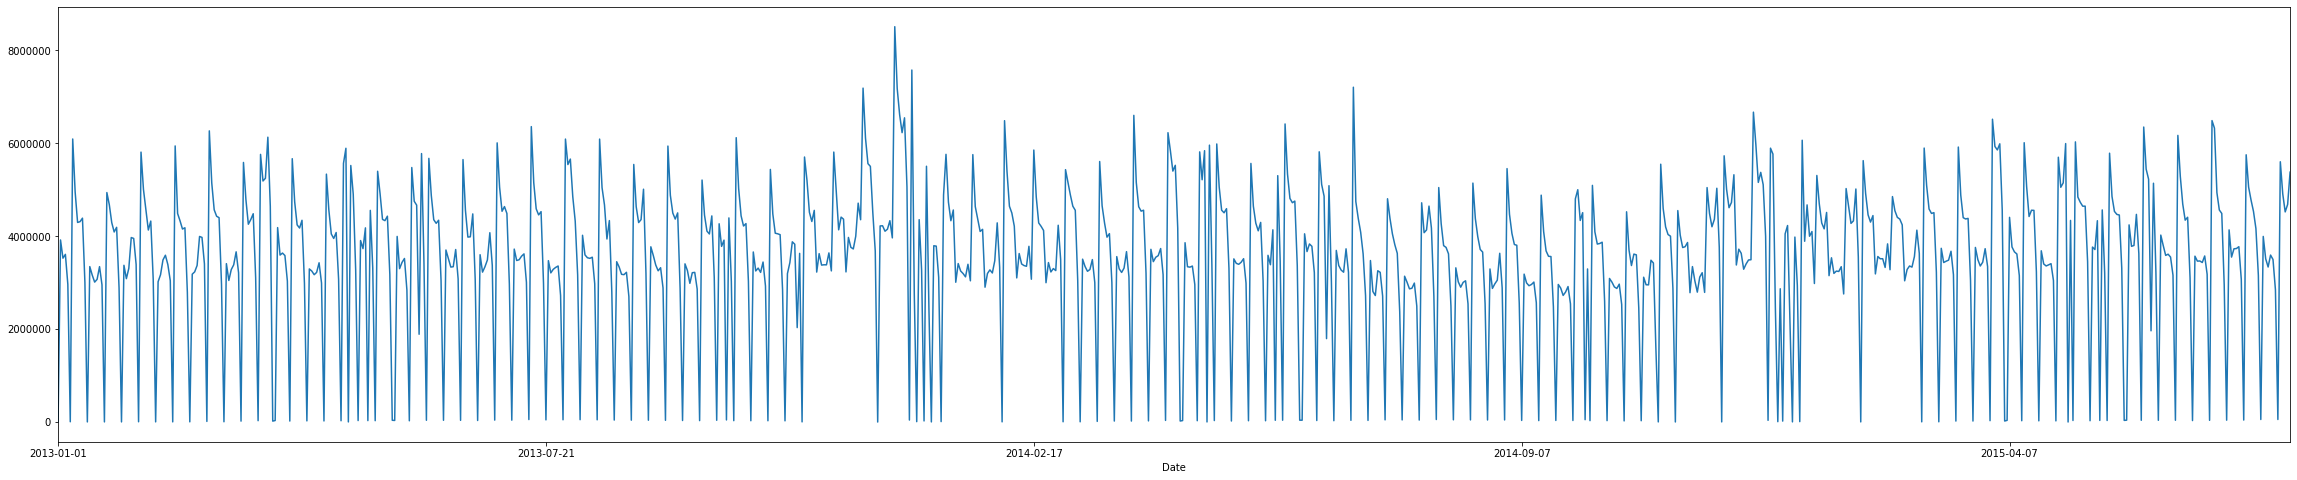

In [53]:
store_a.groupby(['Date'])['Sales'].sum().plot(figsize = (40,8), kind= 'line')
plt.show()

# Weekly Sampling

In [54]:
store_a = store_a.groupby(['Date'])['Sales'].sum().reset_index()
store_a['Date'] = pd.to_datetime(store_a['Date']) 
store_a = store_a.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

In [55]:
store_a

,Date,Sales
0,2013-01-07,20126309
1,2013-01-14,24307784
2,2013-01-21,20493217
3,2013-01-28,23524434
4,2013-02-04,23532505
5,2013-02-11,24145728
6,2013-02-18,22634895
7,2013-02-25,23140563
8,2013-03-04,24263728
9,2013-03-11,24929598


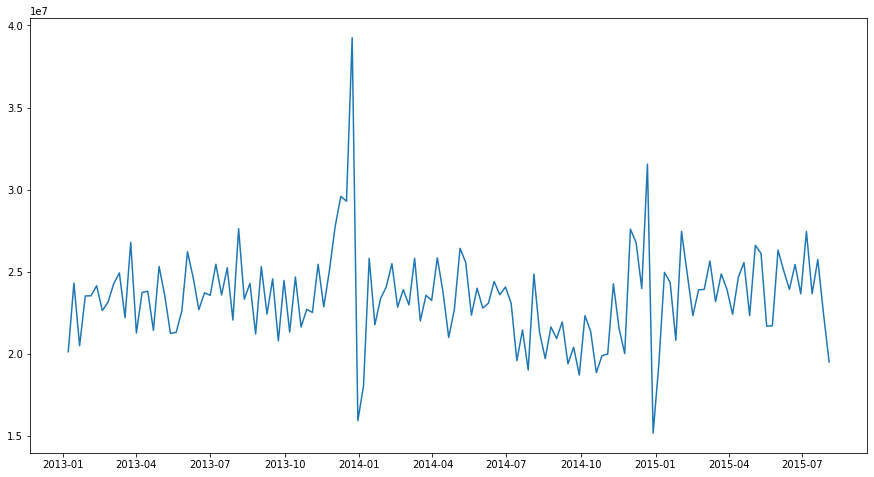

In [56]:
plt.figure(figsize = (15,8))
plt.plot('Date', 'Sales', data= store_a)
plt.show()

# Testing for Stationarity

In [57]:
store_a = store_a.set_index('Date')
series = store_a.iloc[:,0].values
result = adfuller(series)
print("ADF Statistic", result[0])
print("p Value", result[1])
for key,value in result[4].items():
    print(key,value,sep = " : ")

ADF Statistic -10.506582277946958
p Value 1.050461992521558e-18
1% : -3.480118600110386
5% : -2.8833618426136196
10% : -2.578407034974382


### Observation : 

The ADF statistic is far less than the value at 1% significance level, and thus we can safely reject the null Hypothesis which assumes that the time series is non-stationary, and conclude that we have enough statistical evidence to assume that our time series is stationary

# Looking for Seasonality and Trends in the data

<Figure size 1080x576 with 0 Axes>

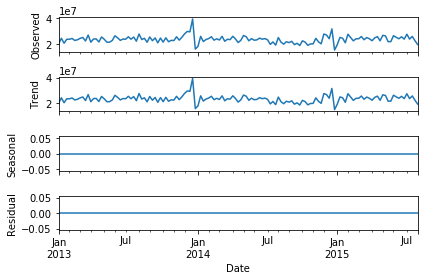

In [58]:
result = seasonal_decompose(store_a, model='additive', freq=1)
plt.figure(figsize = (15,8))
result.plot()
plt.show()

### Observation : 

The time series takes all the data as trend, there is seasonality present in the dataset and there is no residual noice present in the dataset either. The current time series is non-stationary and thus for forecasting we'll have to make it stationary, by differencing

# Persistence Model

In [59]:
store_a.to_csv('store_a.csv')
series = pd.read_csv('store_a.csv', index_col = 0, header = 0, squeeze = True, parse_dates = True)

In [60]:
del store_a

### Observation : 

We will be predicting one year of sales for the Store Type A, so our cut off point will be `series['2014-08-04']`

In [61]:
split_point = '2014-08-03'

dataset, train = series[:split_point], series[split_point:]

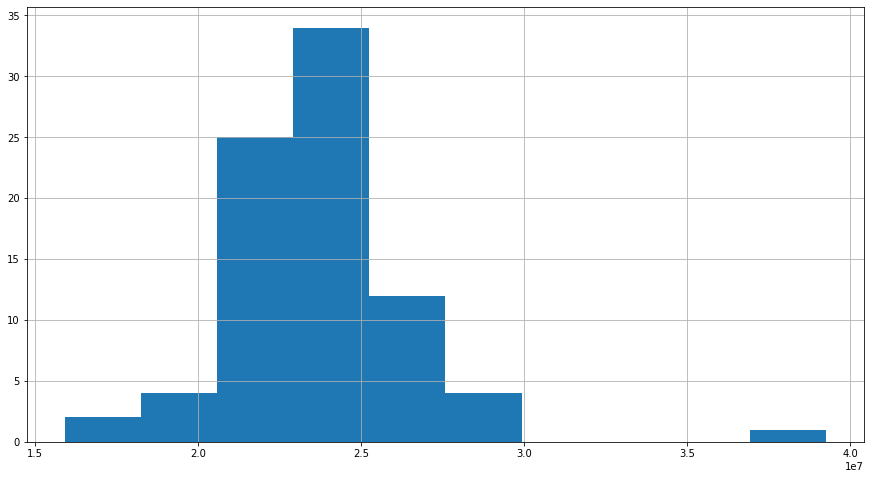

In [62]:
dataset.hist(figsize= (15,8))

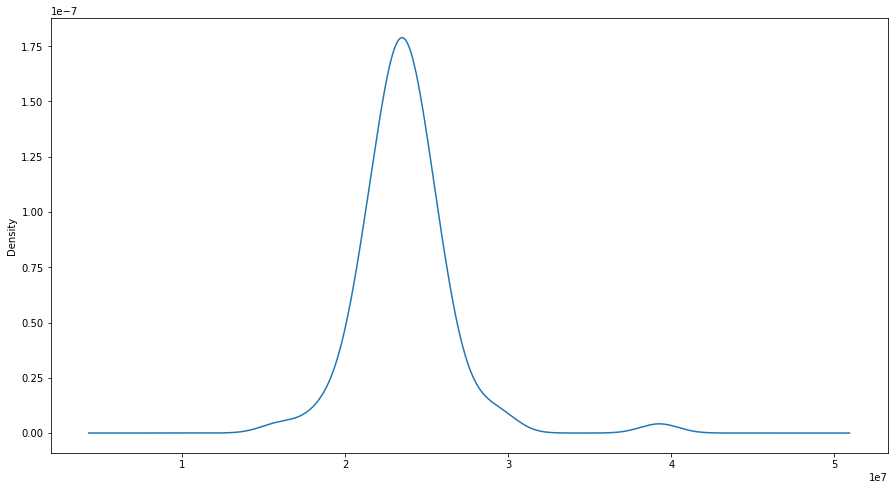

In [63]:
dataset.plot(kind= 'kde', figsize= (15,8))

### Observation :
The datset seem to have a Gaussian Distribution, and thus Using a power Transform may not be required

In [64]:
train_size = int(len(dataset) * 0.5)
train_set, test_set = dataset[0:train_size], dataset[train_size:]
history = [x for x in train_set]
predictions = []

for t in range(len(test_set)):
    # we won't be doing any differncing operation as the series is already stationary
    y_hat = history[-1]
    predictions.append(y_hat)
    observation = test_set[t]
    history.append(observation)
    print("Predicted Value", y_hat, "Actual Value", observation)
rmse = math.sqrt(mean_squared_error(test_set,predictions))
print("Persistence RMSE", rmse)
    

Predicted Value 24681372 Actual Value 21629671
Predicted Value 21629671 Actual Value 22707164
Predicted Value 22707164 Actual Value 22516441
Predicted Value 22516441 Actual Value 25455880
Predicted Value 25455880 Actual Value 22858079
Predicted Value 22858079 Actual Value 25087966
Predicted Value 25087966 Actual Value 27746086
Predicted Value 27746086 Actual Value 29591413
Predicted Value 29591413 Actual Value 29297312
Predicted Value 29297312 Actual Value 39257157
Predicted Value 39257157 Actual Value 15925069
Predicted Value 15925069 Actual Value 18052889
Predicted Value 18052889 Actual Value 25818761
Predicted Value 25818761 Actual Value 21771281
Predicted Value 21771281 Actual Value 23360461
Predicted Value 23360461 Actual Value 24072455
Predicted Value 24072455 Actual Value 25493816
Predicted Value 25493816 Actual Value 22840296
Predicted Value 22840296 Actual Value 23903722
Predicted Value 23903722 Actual Value 22974829
Predicted Value 22974829 Actual Value 25817873
Predicted Val

### Observation : 

That's too high as an error, it essentially means we're off the actual values by these many dollars

# Understanding Residuals

In [65]:
residuals = [test_set[t] - predictions[t] for t in range(len(test_set))]

In [66]:
residuals = pd.DataFrame(residuals)
residuals.describe()

,0
count,4.100000e+01
mean,-1.382557e+05
std,4.692113e+06
min,-2.333209e+07
25%,-2.086259e+06
50%,4.685360e+05
75%,1.845327e+06
max,9.959845e+06


### On averge we're off in every predicted sales amount by -1.382557e+05, so we'll have to add this bias term back to the prediction to account for the actual value

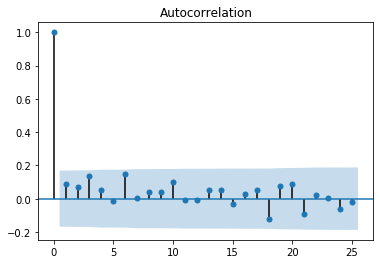

In [67]:
plot_acf(series, lags= 25)
plt.show()

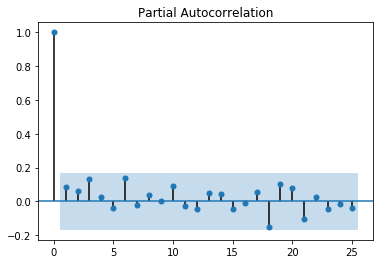

In [68]:
plot_pacf(series, lags= 25)
plt.show()

### Observation :

There seems to be no correlation between the lag variables

# Grid Search ARIMA

In [69]:
def evaluate_arima(dataset, arima_order):
    
    X = dataset.values
    X = X.astype('float32')
   
    train_size =  int(len(X) * 0.5)

    train_set, test_set = X[0:train_size], X[train_size:] 
    
    history = [x for x in train_set]
    predictions = []

    bias = -1.382557e+05
    for t in range(len(test_set)):

        model = ARIMA(history, arima_order)
        model_fit = model.fit(trend = 'nc', disp = 0)
        y_hat = bias + float(model_fit.forecast()[0])

        #y_hat =  boxcox_inverse(y_hat, lam)

        predictions.append(y_hat)
        observation = test_set[t]
        history.append(observation)
        
    rmse = math.sqrt(mean_squared_error(test_set,predictions))
    
    return rmse


In [70]:
def make_arima(dataset, p_range, d_range, q_range):
    best_rmse, best_config = float('inf'), None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:   
                    config = (p,d,q)
                    rmse = evaluate_arima(dataset, config)
                    if rmse <  best_rmse:
                        best_rmse = rmse
                        best_config = config
                    print("Model RMSE", rmse, "Config", config, sep = " : ")
                except:
                    continue
    print("Best RMSE", best_rmse, "Best Config", best_config, sep = " : ")

In [71]:
p_range = range(0,10)
d_range = range(0,3)
q_range = range(0,10)
#make_arima(dataset, p_range, d_range, q_range)

### Observation : 

The RMSE score improved from Persistence : 4636601.067080823 to 4110148.105004865, the RMSE values are too high at Weekly Level Aggregation

# Daily Trend :  Store 1 ( Store Type C )

In [72]:
store_1 = original_dataset[original_dataset.Store == 1]

In [73]:
store_1_daily = store_1[['Date','Sales']]

# Testing for Stationarity

In [74]:
store_1_daily['Date'] = pd.to_datetime(store_1_daily['Date']) 
store_1_daily = store_1_daily.set_index('Date')
series = store_1_daily.iloc[:,0].values


In [75]:
result = adfuller(series)
print("ADF Statistic", result[0])
print("p Value", result[1])
for key,value in result[4].items():
    print(key,value,sep = " : ")

ADF Statistic -5.399623337824002
p Value 3.3933795244320705e-06
1% : -3.4389045244994096
5% : -2.8653156040031176
10% : -2.5687805115003


### Observation : 

The  statistic is below the 1% value and thus we can reject the Null Hypothesis that the time series data is non-stationary

# Looking for Seasonality and Trends in the data

<Figure size 1080x576 with 0 Axes>

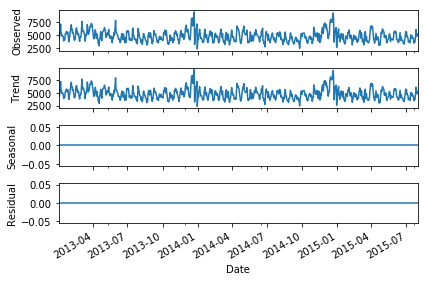

In [76]:
result = seasonal_decompose(store_1_daily, model='additive', freq=1)
plt.figure(figsize = (15,8))
result.plot()
plt.show()

### Observation : 

The dataset doesn't show any trend or seasonality patterns per se, and thus differencing won't be required

# Visualizing Data

In [77]:
store_1_daily.to_csv('store_1_daily.csv')
series_daily = pd.read_csv('store_1_daily.csv', index_col = 0, header = 0, squeeze = True, parse_dates = True)

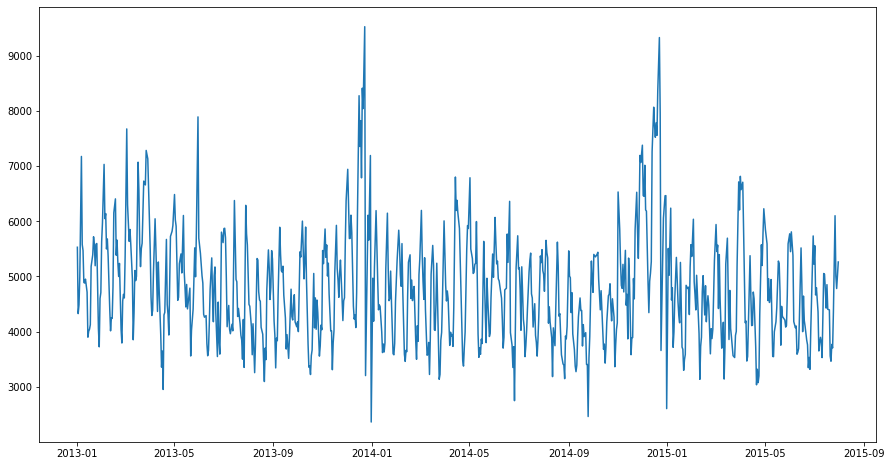

In [78]:
plt.figure(figsize = (15,8))
plt.plot(series_daily)

In [79]:
split_point = '2014-09-01'

dataset, validation = series_daily[:split_point], series_daily[split_point:]

# Persistence Model - Daily

In [80]:
train_size = int(len(dataset) * 0.5)
train_set, test_set = dataset[0:train_size], dataset[train_size:]
history = [x for x in train_set]
predictions = []

for t in range(len(test_set)):
    # we won't be doing any differncing operation as the series is already stationary
    y_hat = history[-1]
    predictions.append(y_hat)
    observation = test_set[t]
    history.append(observation)
    print("Predicted Value", y_hat, "Actual Value", observation)
rmse = math.sqrt(mean_squared_error(test_set,predictions))
print("Persistence RMSE", rmse)

Predicted Value 4119 Actual Value 4035
Predicted Value 4035 Actual Value 5471
Predicted Value 5471 Actual Value 5233
Predicted Value 5233 Actual Value 5861
Predicted Value 5861 Actual Value 5348
Predicted Value 5348 Actual Value 5572
Predicted Value 5572 Actual Value 5009
Predicted Value 5009 Actual Value 5242
Predicted Value 5242 Actual Value 4681
Predicted Value 4681 Actual Value 4014
Predicted Value 4014 Actual Value 4017
Predicted Value 4017 Actual Value 3310
Predicted Value 3310 Actual Value 3795
Predicted Value 3795 Actual Value 4016
Predicted Value 4016 Actual Value 5071
Predicted Value 5071 Actual Value 5927
Predicted Value 5927 Actual Value 5143
Predicted Value 5143 Actual Value 4936
Predicted Value 4936 Actual Value 4623
Predicted Value 4623 Actual Value 5058
Predicted Value 5058 Actual Value 5297
Predicted Value 5297 Actual Value 4600
Predicted Value 4600 Actual Value 4201
Predicted Value 4201 Actual Value 4561
Predicted Value 4561 Actual Value 4614
Predicted Value 4614 Actu

# Checking Requirement for BoxCox Trasnformation

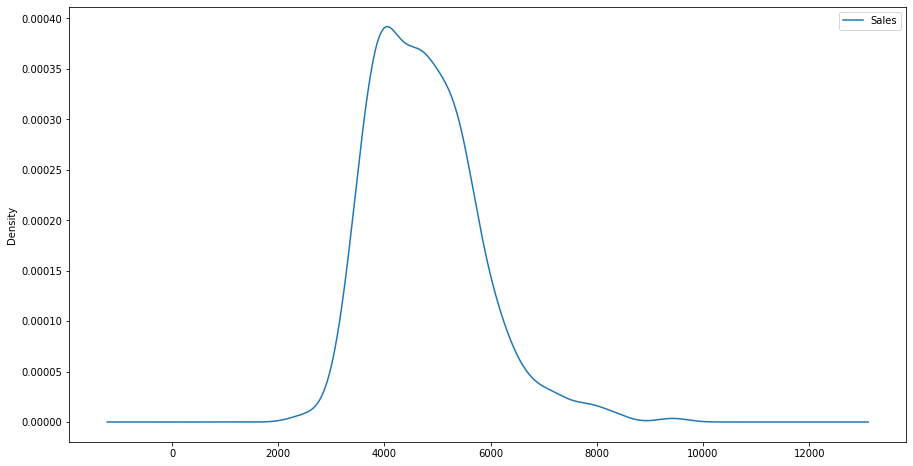

In [81]:
store_1_daily.plot(kind = 'kde', figsize = (15,8))

### Observation : 

The curve is not gaussian, and is skewed to the right a transformation of the data would be helpful in making better predictions

# Auto-Correlation & Partial-Autocorrelation Plot

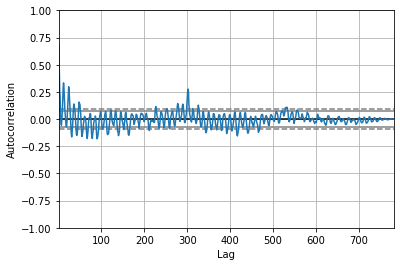

In [82]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series_daily)
plt.show()

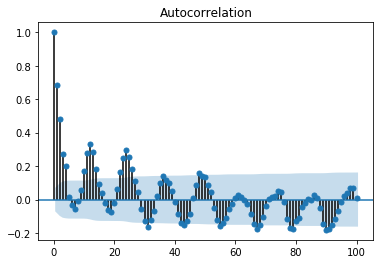

In [83]:
plot_acf(series_daily, lags= 100)
plt.show()

### Observation:

p value ranges from 0 to 17

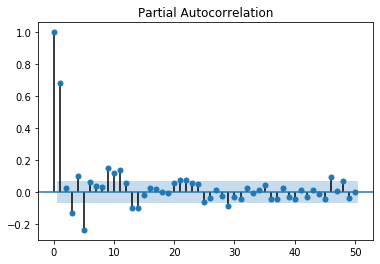

In [84]:
plot_pacf(series_daily, lags= 50)
plt.show()

### Observation : 

q value range from 0 to 10

### Observation : 

The plots show heavy correlation between the Lag Variables, we'll be using Grid Search and Hyper-Parameter Tuning to determine the best Model

# Forecasting : Grid Search ARIMA 

In [85]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return math.exp(value)
    return math.exp(math.log(lam * value + 1) / lam)

In [86]:
def evaluate_arima(dataset, arima_order):
    
    X = dataset.values
    X = X.astype('float32')
   
    train_size =  int(len(X) * 0.5)

    train_set, test_set = X[0:train_size], X[train_size:] 
    
    history = [x for x in train_set]
    predictions = []

    bias = -1.382557e+05
    for t in range(len(test_set)):
        transformed, lam  = boxcox(history)
        if lam < -5:
            transformed,lam = history,1

        model = ARIMA(transformed, arima_order)
        model_fit = model.fit(trend = 'nc', disp = 0)
        y_hat = model_fit.forecast()[0]

        y_hat =  boxcox_inverse(y_hat, lam)

        predictions.append(y_hat)
        observation = test_set[t]
        history.append(observation)
       
    rmse = math.sqrt(mean_squared_error(test_set,predictions))
    return rmse


In [87]:
def make_arima(dataset, p_range, d_range, q_range):
    best_rmse, best_config = float('inf'), None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:   
                    config = (p,d,q)
                    rmse = evaluate_arima(dataset, config)
                    if rmse <  best_rmse:
                        best_rmse = rmse
                        best_config = config
                    print("Model RMSE", rmse, "Config", config, sep = " : ")
                except:
                    continue
    print("Best RMSE", best_rmse, "Best Config", best_config, sep = " : ")

In [88]:
p_range = range(15,17)
d_range = range(0,2)
q_range = range(0,10)
#make_arima(dataset, p_range, d_range,q_range)

### Selected Model Configurations : (DO NOT RUN THE ABOVE CELL)

Model RMSE : 777.5129955646087 : Config : (12, 0, 0)

# ARIMA : (12,0,0)

In [89]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return math.exp(value)
    return math.exp(math.log(lam * value + 1) / lam)

In [93]:
def evaluate_arima(dataset, arima_order):
    
    X = dataset.values
    X = X.astype('float32')
   
    train_size =  int(len(X) * 0.5)

    train_set, test_set = X[0:train_size], X[train_size:] 
    
    history = [x for x in train_set]
    predictions = []

    for t in range(len(test_set)):
        transformed, lam  = boxcox(history)
        if lam < -5:
            transformed,lam = history,1

        model = ARIMA(transformed, arima_order)
        model_fit = model.fit(trend = 'nc', disp = 0)
        y_hat = model_fit.forecast()[0]

        y_hat =  boxcox_inverse(y_hat, lam)

        predictions.append(y_hat)
        observation = test_set[t]
        history.append(observation)
        print("Predicted : ", y_hat, "Actual : ", observation)
       
    rmse = math.sqrt(mean_squared_error(test_set,predictions))
    return (rmse, test_set,predictions)


In [94]:
rmse, test_set,predictions = evaluate_arima(dataset, (12,0,0))

Predicted :  3818.7046610933685 Actual :  4035.0
Predicted :  4017.1517347997155 Actual :  5471.0
Predicted :  4980.662331024305 Actual :  5233.0
Predicted :  5160.113345331661 Actual :  5861.0
Predicted :  5319.438329784822 Actual :  5348.0
Predicted :  5091.093022653309 Actual :  5572.0
Predicted :  5000.363415312556 Actual :  5009.0
Predicted :  4816.38237853208 Actual :  5242.0
Predicted :  4733.075320826801 Actual :  4681.0
Predicted :  4567.414796578395 Actual :  4014.0
Predicted :  3885.031878110029 Actual :  4017.0
Predicted :  4311.383996393419 Actual :  3310.0
Predicted :  3596.690244556614 Actual :  3795.0
Predicted :  4350.060192585228 Actual :  4016.0
Predicted :  4416.803996461699 Actual :  5071.0
Predicted :  5271.772110242874 Actual :  5927.0
Predicted :  5819.004924798503 Actual :  5143.0
Predicted :  5139.978686697467 Actual :  4936.0
Predicted :  4945.762389156883 Actual :  4623.0
Predicted :  4578.49387928801 Actual :  5058.0
Predicted :  4752.39028798027 Actual :  

Predicted :  4345.057850396377 Actual :  3912.0
Predicted :  3642.2532533463786 Actual :  3971.0
Predicted :  4096.061828829574 Actual :  4616.0
Predicted :  4367.101572320347 Actual :  5407.0
Predicted :  4916.742656591974 Actual :  4985.0
Predicted :  4810.980580355332 Actual :  6071.0
Predicted :  5666.589528835504 Actual :  5614.0
Predicted :  5519.969141656915 Actual :  5229.0
Predicted :  4667.902797163917 Actual :  5278.0
Predicted :  5136.808405885187 Actual :  4957.0
Predicted :  4740.358014415554 Actual :  4923.0
Predicted :  4645.259413049215 Actual :  4607.0
Predicted :  4584.499295459972 Actual :  4207.0
Predicted :  4217.6390612335 Actual :  3702.0
Predicted :  4190.637522508682 Actual :  3901.0
Predicted :  4349.2046305142685 Actual :  4757.0
Predicted :  4922.4889892728015 Actual :  4788.0
Predicted :  5045.21800888273 Actual :  5770.0
Predicted :  5576.310473999344 Actual :  5256.0
Predicted :  5419.405095948527 Actual :  6362.0
Predicted :  5716.081784526027 Actual : 

# Performance on Test Set

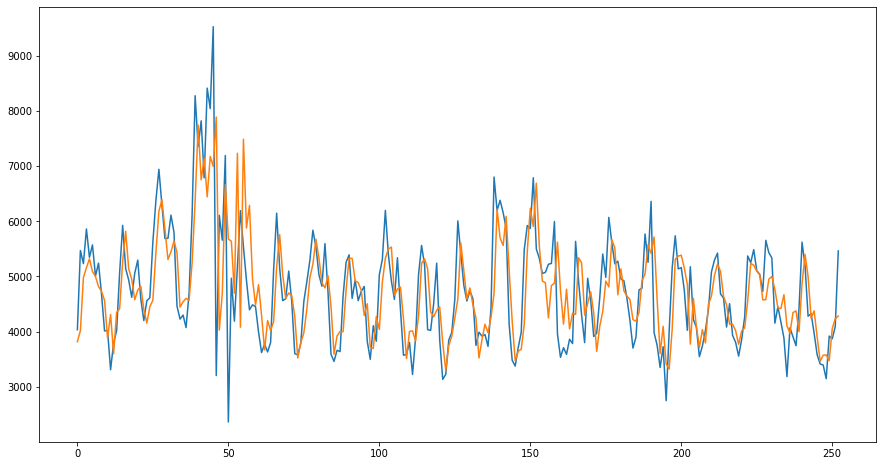

In [97]:
plt.figure(figsize = (15,8))
plt.plot(test_set)
plt.plot(predictions)
plt.show()

# Looking for Bias Term in the Predictions

In [98]:
residuals = [test_set[t] - predictions[t] for t in range(len(test_set))]

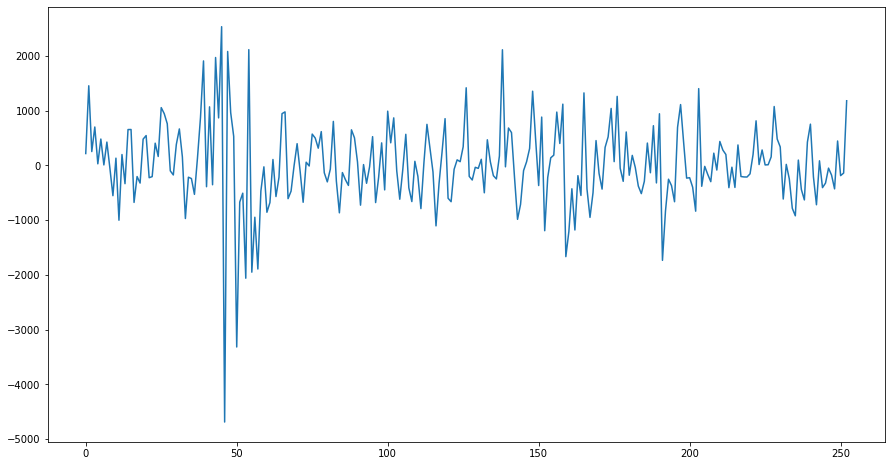

In [99]:
plt.figure(figsize = (15,8))
plt.plot(residuals)
plt.show()

In [100]:
residuals = pd.DataFrame(residuals)
residuals.describe()

,0
count,253.000000
mean,9.369148
std,778.997589
min,-4686.443394
25%,-369.882733
50%,-38.259413
75%,425.958603
max,2532.731977


### Observation : 

On average we're by $9.369148 on every prediction,so we'll use this bias to correct our predictions and add this term to every prediction made

# ARIMA (12,0,0) with addition of Bias term

In [101]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return math.exp(value)
    return math.exp(math.log(lam * value + 1) / lam)

In [103]:
def evaluate_arima(dataset, arima_order):
    
    X = dataset.values
    X = X.astype('float32')
   
    train_size =  int(len(X) * 0.5)

    train_set, test_set = X[0:train_size], X[train_size:] 
    
    history = [x for x in train_set]
    predictions = []

    bias = 9.369148
    for t in range(len(test_set)):
        transformed, lam  = boxcox(history)
        if lam < -5:
            transformed,lam = history,1

        model = ARIMA(transformed, arima_order)
        model_fit = model.fit(trend = 'nc', disp = 0)
        y_hat = model_fit.forecast()[0]

        y_hat = bias + boxcox_inverse(y_hat, lam)

        predictions.append(y_hat)
        observation = test_set[t]
        history.append(observation)
        print("Predicted : ", y_hat, "Actual : ", observation)
       
    rmse = math.sqrt(mean_squared_error(test_set,predictions))
    return (rmse, test_set,predictions)


In [104]:
rmse, test_set,predictions = evaluate_arima(dataset, (12,0,0))

Predicted :  3828.0738090933687 Actual :  4035.0
Predicted :  4026.5208827997158 Actual :  5471.0
Predicted :  4990.031479024305 Actual :  5233.0
Predicted :  5169.48249333166 Actual :  5861.0
Predicted :  5328.8074777848215 Actual :  5348.0
Predicted :  5100.462170653309 Actual :  5572.0
Predicted :  5009.732563312556 Actual :  5009.0
Predicted :  4825.75152653208 Actual :  5242.0
Predicted :  4742.4444688268 Actual :  4681.0
Predicted :  4576.783944578395 Actual :  4014.0
Predicted :  3894.4010261100293 Actual :  4017.0
Predicted :  4320.753144393419 Actual :  3310.0
Predicted :  3606.059392556614 Actual :  3795.0
Predicted :  4359.429340585228 Actual :  4016.0
Predicted :  4426.173144461699 Actual :  5071.0
Predicted :  5281.141258242874 Actual :  5927.0
Predicted :  5828.374072798503 Actual :  5143.0
Predicted :  5149.347834697467 Actual :  4936.0
Predicted :  4955.131537156883 Actual :  4623.0
Predicted :  4587.86302728801 Actual :  5058.0
Predicted :  4761.75943598027 Actual :  5

Predicted :  4354.426998396377 Actual :  3912.0
Predicted :  3651.622401346379 Actual :  3971.0
Predicted :  4105.430976829573 Actual :  4616.0
Predicted :  4376.470720320347 Actual :  5407.0
Predicted :  4926.111804591974 Actual :  4985.0
Predicted :  4820.3497283553315 Actual :  6071.0
Predicted :  5675.958676835504 Actual :  5614.0
Predicted :  5529.338289656915 Actual :  5229.0
Predicted :  4677.271945163917 Actual :  5278.0
Predicted :  5146.177553885187 Actual :  4957.0
Predicted :  4749.727162415554 Actual :  4923.0
Predicted :  4654.628561049215 Actual :  4607.0
Predicted :  4593.868443459972 Actual :  4207.0
Predicted :  4227.0082092335 Actual :  3702.0
Predicted :  4200.006670508682 Actual :  3901.0
Predicted :  4358.573778514268 Actual :  4757.0
Predicted :  4931.858137272801 Actual :  4788.0
Predicted :  5054.58715688273 Actual :  5770.0
Predicted :  5585.679621999344 Actual :  5256.0
Predicted :  5428.774243948526 Actual :  6362.0
Predicted :  5725.450932526027 Actual :  3

# Performance on Test Set

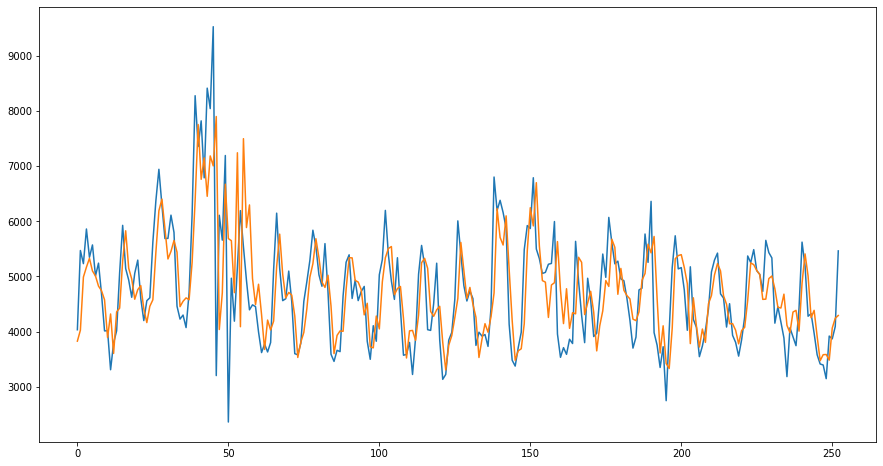

In [105]:
plt.figure(figsize = (15,8))
plt.plot(test_set)
plt.plot(predictions)
plt.show()

In [107]:
residuals = [test_set[t] - predictions[t] for t in range(len(test_set))]

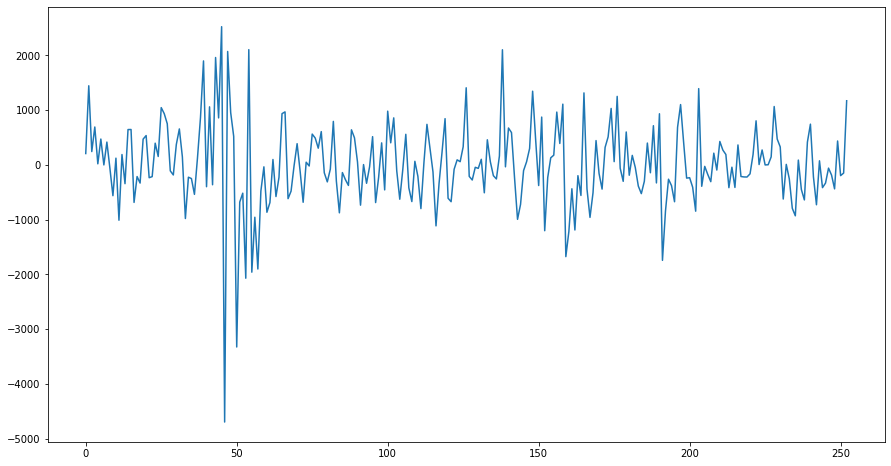

In [108]:
plt.figure(figsize = (15,8))
plt.plot(residuals)
plt.show()

In [109]:
residuals = pd.DataFrame(residuals)
residuals.describe()

,0
count,2.530000e+02
mean,4.010855e-07
std,7.789976e+02
min,-4.695813e+03
25%,-3.792519e+02
50%,-4.762856e+01
75%,4.165895e+02
max,2.523363e+03


### Observation :

We have successfully extracted all the information out from the residuals

# Finalizing the model

In [111]:
from statsmodels.tsa.arima_model import ARIMAResults

In [112]:
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__
 
X = dataset.values
X = X.astype('float32')

transformed, lam  = boxcox(X)
if lam < -5:
    transformed,lam = X,1

model = ARIMA(transformed, (12,0,0))
model_fit = model.fit(trend = 'nc', disp = 0)
bias = 9.369148

model_fit.save('model_fit.pkl')
np.save('lambda.npy',[lam])
np.save('bias.npy',[bias])
    
    



# Validate Model

In [113]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return math.exp(value)
    return math.exp(math.log(lam * value + 1) / lam)

In [117]:
def evaluate_model(dataset,validation, arima_order):
    X = dataset.values
    X = X.astype('float32')
    
    y = validation.values
    y = y.astype('float32')
    
    model_fit = ARIMAResults.load('model_fit.pkl')
    bias = np.load('bias.npy')[0]
    lam = np.load('lambda.npy')[0]
    
    history = [x for x in X]
    predictions = []
    y_hat = model_fit.forecast()[0]
    y_hat = bias+ boxcox_inverse(y_hat, lam)
    
    predictions.append(y_hat)
    
    print("Predicted : ", y_hat , "Actual : ", y[0])
    
    for t in range(1, len(y)):
        transformed, lam = boxcox(history)
        if lam < -5:
            transformed, lam = history,1
        model = ARIMA(transformed, (12,0,0))
        model_fit = model.fit(trend = 'nc', disp = 0)
        
        y_hat = model_fit.forecast()[0]
        
        y_hat = bias + boxcox_inverse(y_hat, lam)
        
        predictions.append(y_hat)
        observation = y[t]
        
        history.append(observation)
        
        print("Predicted : ", y_hat , "Actual : ", observation)
        
    rmse = math.sqrt(mean_squared_error(y, predictions))
    return (rmse, y, predictions)

In [118]:
rmse, y, predictions = evaluate_model(dataset,validation, (12,0,0))

Predicted :  5339.928281013911 Actual :  5464.0
Predicted :  5339.928281013911 Actual :  5008.0
Predicted :  4729.900666805756 Actual :  4978.0
Predicted :  4500.2064611334745 Actual :  4346.0
Predicted :  4428.668451669961 Actual :  4706.0
Predicted :  4056.011695774182 Actual :  3959.0
Predicted :  3914.959272057996 Actual :  3676.0
Predicted :  3452.2805273438285 Actual :  3377.0
Predicted :  3600.1137870820344 Actual :  3275.0
Predicted :  3474.0745006256707 Actual :  3392.0
Predicted :  3700.562220397529 Actual :  3906.0
Predicted :  4167.885941647342 Actual :  4270.0
Predicted :  4542.177530346203 Actual :  4611.0
Predicted :  4699.922367416713 Actual :  4381.0
Predicted :  4519.745443498652 Actual :  4383.0
Predicted :  4316.37668749321 Actual :  3740.0
Predicted :  3938.880871364991 Actual :  4128.0
Predicted :  3871.365955468644 Actual :  3911.0
Predicted :  3886.1144524850333 Actual :  3982.0
Predicted :  3651.0703603327024 Actual :  3407.0
Predicted :  3604.150680758487 Actu

Predicted :  3915.228150491063 Actual :  3547.0
Predicted :  3402.8597654742016 Actual :  3531.0
Predicted :  3733.0968447178275 Actual :  3932.0
Predicted :  4161.963389759422 Actual :  4005.0
Predicted :  4289.844852730693 Actual :  5208.0
Predicted :  5051.0471810583385 Actual :  6714.0
Predicted :  6106.8538725862145 Actual :  6206.0
Predicted :  5569.398554620312 Actual :  6816.0
Predicted :  6092.257281084143 Actual :  6574.0
Predicted :  6153.317084426933 Actual :  6709.0
Predicted :  5570.572724098106 Actual :  4163.0
Predicted :  4299.990838866958 Actual :  4194.0
Predicted :  3826.625311586889 Actual :  3467.0
Predicted :  3895.246477097697 Actual :  3549.0
Predicted :  3293.4430653851036 Actual :  4173.0
Predicted :  4648.484171086798 Actual :  5377.0
Predicted :  5456.200532270419 Actual :  4648.0
Predicted :  5148.815785741559 Actual :  4110.0
Predicted :  4873.416711724918 Actual :  4116.0
Predicted :  4978.031066323229 Actual :  4718.0
Predicted :  4900.429403976264 Actu

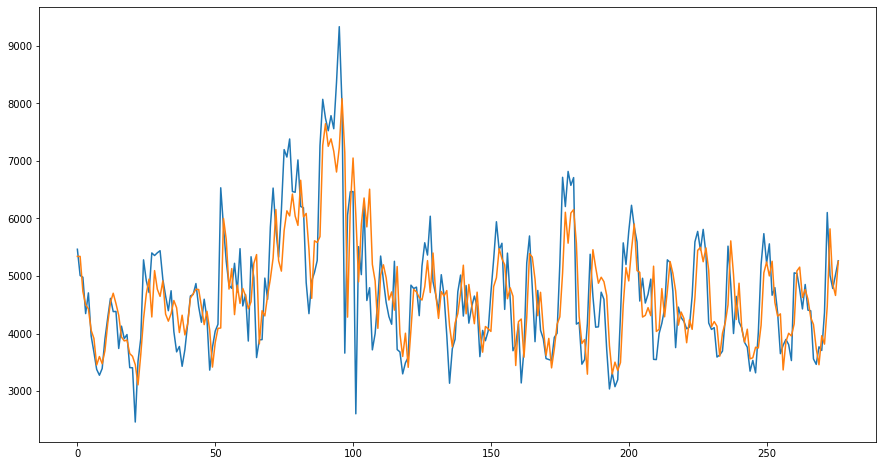

In [119]:
plt.figure(figsize = (15,8))
plt.plot(y)
plt.plot(predictions)
plt.show()

### Results : 

Final RMSE : $ 712.030168123197, Overall we're off by 712.030168123197 per prediction